### Imports and data reading - RUN FIRST

In [1]:
import pandas as pd
from visualization import data_visualization, sales_for_top_countries, customer_trend_per_month, top_selling_items
from helpers import read_and_describe, description_stock_mapping
import matplotlib.pyplot as plt
import warnings        
warnings.filterwarnings("ignore") # ignores warnings

df = read_and_describe('data.csv')

Data types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541612 entries, 0 to 541611
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541612 non-null  object        
 1   StockCode    541612 non-null  object        
 2   Description  540158 non-null  object        
 3   Quantity     541612 non-null  int64         
 4   InvoiceDate  541612 non-null  datetime64[ns]
 5   UnitPrice    541612 non-null  float64       
 6   CustomerID   406579 non-null  float64       
 7   Country      541612 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Numeric data description:

            Quantity      UnitPrice     CustomerID
count  541612.000000  541612.000000  406579.000000
mean        9.549451       4.611650   15289.307613
std       218.140589      96.786168    1712.884774
min    -80995.000000  -11062.060000   12346.000000
25%    

##### 135080 customerIDs are missing
##### The min and max in Quantity and UnitPrice are alerting - Cleaning is required
##### 1454 missing description

### Data visualization - First look to get more insights

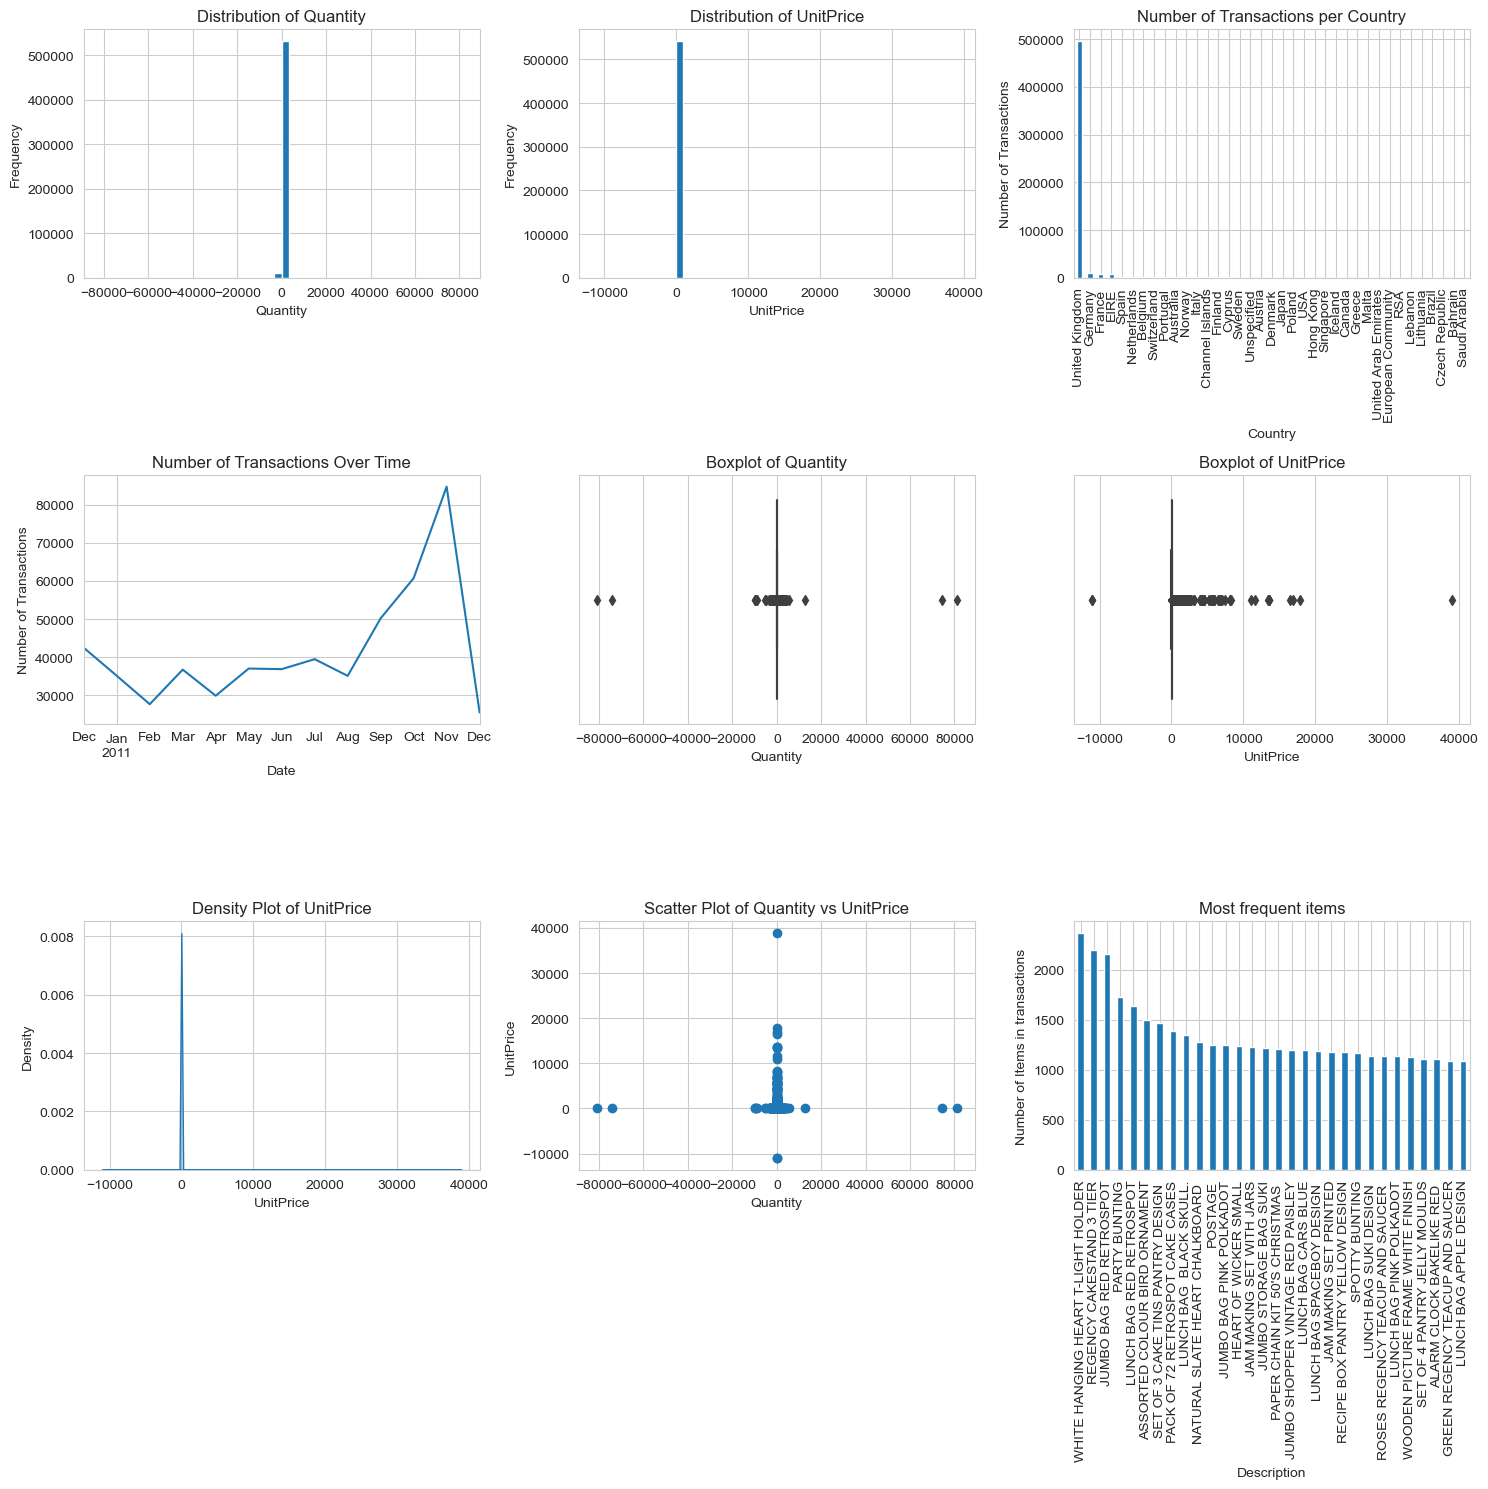

In [2]:
data_visualization(df)

###### - The wide spread observed in the data for both quantity and unit price suggests the presence of outliers, which is further corroborated by the boxplot visualizations.
###### - A significant portion of the data originates from the United Kingdom.
###### - The dataset encompasses transactions spanning from December 2010 to November 2011.
###### - 'POSTAGE' is one of the most ferquent products which is not an actual product.

### Cleaning data

#### Part 1: Handle missing cusomter Ids

In [3]:
# First, sort the DataFrame by InvoiceID and CustomerID
df.sort_values(by=['InvoiceNo', 'CustomerID'], inplace=True)

# Forward fill CustomerID within each InvoiceID group
df['CustomerID'] = df.groupby('InvoiceNo')['CustomerID'].ffill()

# Check the results
print(f'After forward filling: {df["CustomerID"].isna().sum()}\n')

# Fill missing CustomerID values with a specific value 'Unknown'
df['CustomerID'].fillna('UnknownId', inplace=True)

# Check the results
print(f'After Assigning "UnknownId" : {df["CustomerID"].isna().sum()}\n')

After forward filling: 135033

After Assigning "UnknownId" : 0



##### Using InvoiceId didn't help, assigned 'Unknown' to all missing customerIds since the missing data is huge and it's not significant for association rules since we mainly care about the transaction items

#### Part 2: Stock code and description handling

In [4]:
# Triming
df['Description'] = df['Description'].str.strip()
description_stock_mapping(df)

Number of unique descriptions 4211
Number of unique StockCode 4070


Description
check                            146
?                                 47
damages                           43
damaged                           43
found                             25
                                ... 
GARLAND WITH HEARTS AND BELLS      1
GARLAND WITH STARS AND BELLS       1
GARLAND WOODEN HAPPY EASTER        1
GARLAND, MAGIC GARDEN 1.8M         1
wrongly sold sets                  1
Name: StockCode, Length: 4211, dtype: int64

146       1
47        1
43        2
25        1
20        1
15        1
14        1
9         2
8         1
7         2
6         2
5         5
4         3
3         5
2       149
1      4034
Name: StockCode, dtype: int64

##### The mapping between stock and description is 1:1 for the majority of unique descriptions(4051)
##### Some descriptions are mapped to the same stock code, we can unify them and choose one stockcode for them (First one)
##### There are 112 different stock codes that are not mapped to any description which requires handling

In [5]:
# Identify Descriptions linked to multiple StockCodes
multi_stockcode_descriptions = df.groupby('Description')['StockCode'].nunique()
multi_stockcode_descriptions = multi_stockcode_descriptions[multi_stockcode_descriptions >= 2].index

# Create a dictionary mapping Description to its first StockCode
first_stockcode_map = df[df['Description'].isin(multi_stockcode_descriptions)].groupby('Description')['StockCode'].first().to_dict()

# Update the DataFrame: set the StockCode to the first StockCode for these Descriptions
df.loc[df['Description'].isin(multi_stockcode_descriptions), 'StockCode'] = df['Description'].map(first_stockcode_map)

# Check for missing values
display(description_stock_mapping(df))
df.isna().sum()

Number of unique descriptions 4211
Number of unique StockCode 3935


Description
*Boombox Ipod Classic                  1
RASTA IN BATH W SPLIFF ASHTRAY         1
RECIPE BOX BLUE SKETCHBOOK DESIGN      1
RECIPE BOX PANTRY YELLOW DESIGN        1
RECIPE BOX RETROSPOT                   1
                                      ..
FRESHWATER PEARL BRACELET GOLD         1
FRESHWATER PEARL BRACELET IVORY        1
FRIDGE MAGNETS LA VIE EN ROSE          1
FRIDGE MAGNETS LES ENFANTS ASSORTED    1
wrongly sold sets                      1
Name: StockCode, Length: 4211, dtype: int64

1    4211
Name: StockCode, dtype: int64

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

##### Now each description is mapped to only one stock code
##### There are 1454 records with missing description that need to be filled

In [6]:
# Create a mapping from StockCode to Description for non-null descriptions
stockcode_description_map = df.dropna(subset=['Description']).set_index('StockCode')['Description'].to_dict()

# Fill missing descriptions based on the StockCode to Description mapping
df['Description'] = df['Description'].fillna(df['StockCode'].map(stockcode_description_map))

display(df.isna().sum())

# Remove all records left with missing description 
df = df.dropna(subset=['Description'])
df.isna().sum()

InvoiceNo        0
StockCode        0
Description    126
Quantity         0
InvoiceDate      0
UnitPrice        0
CustomerID       0
Country          0
dtype: int64

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

##### Only 122 records out of 1454 was dropped because there is no way to map their values

In [7]:
print(df[~df['Description'].str.strip().str.contains(' ')]['Description'].unique())

['POSTAGE' 'CARRIAGE' 'Manual' 'amazon' '?' 'SOMBRERO' 'check' 'damages'
 'DAMAGED' 'faulty' 'Found' 'found' 'counted' 'Dotcom' 'samples/damages'
 'Amazon' 'showroom' 'MIA' 'Adjustment' 'damages/display' 'broken' '?lost'
 'damages?' 'cracked' 'Damaged' 'SAMPLES' 'returned' 'damaged' 'Display'
 'Missing' 'adjustment' 'adjust' 'crushed' 'samples' 'mailout' 'wet/rusty'
 'damages/dotcom?' 'smashed' 'missing' 'FOUND' 'dotcom' 'FBA' 'ebay'
 'Damages/samples' '?display?' '?missing' 'Crushed' 'test' '??' 'Dagamed'
 'WET/MOULDY' 'mouldy' 're-adjustment' 'Breakages' '20713' 'Damages'
 'CHECK' 'missing?' '???lost' 'dotcomstock' 'check?' '????missing'
 '???missing' 'AMAZON' 'wet?' 'lost??' '???' 'wet' '????damages????'
 'lost' 'Discount']


In [8]:
# Remove records with single-word descriptions except 'SOMBRERO '
df = df[(df['Description'].str.strip().str.contains(' ')) | (df['Description'].str.strip() == 'SOMBRERO')]

##### Removed all records with invalid descriptions

#### Part 3: Numerical values cleaning

##### Part 3 - a: Price analysis

In [9]:
# Show prices larger than 650 - after try and error
df[(df['UnitPrice'].abs() > 650)].sort_values(by='InvoiceDate')['Description'].unique()

array(['DOTCOM POSTAGE', 'AMAZON FEE', 'Bank Charges', 'Adjust bad debt',
       'CRUK Commission'], dtype=object)

In [10]:
negative_prices = df[df['UnitPrice'] <= 0].sort_values(by='UnitPrice')
print(negative_prices['UnitPrice'].value_counts())
negative_prices.head(10)

 0.00        1906
-11062.06       2
Name: UnitPrice, dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299919,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,UnknownId,United Kingdom
299918,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,UnknownId,United Kingdom
538208,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.00,UnknownId,United Kingdom
256610,559503,21763,VINTAGE WOODEN BAR STOOL,1,2011-07-08 15:06:00,0.00,UnknownId,United Kingdom
255987,559423,71143,ANTIQUE SILVER BOOK MARK WITH BEADS,-14,2011-07-08 12:06:00,0.00,UnknownId,United Kingdom
255900,559414,22855,FINE WICKER HEART,-4,2011-07-08 10:52:00,0.00,UnknownId,United Kingdom
255899,559410,84341B,SMALL PINK MAGIC CHRISTMAS TREE,-179,2011-07-08 10:51:00,0.00,UnknownId,United Kingdom
255898,559405,22863,SOAP DISH BROCANTE,-7,2011-07-08 10:50:00,0.00,UnknownId,United Kingdom
255897,559402,21635,MADRAS NOTEBOOK LARGE,-8,2011-07-08 10:49:00,0.00,UnknownId,United Kingdom
255869,559398,21169,YOU'RE CONFUSING ME METAL SIGN,-70,2011-07-08 10:48:00,0.00,UnknownId,United Kingdom


##### All the large unit prices are not actual products and can be safely removed
##### There are 2 high negative prices that represents "Adjust bad debt" which can be removed
##### Multiple 0 prices for negative quanties which can be removed

In [11]:
# Filter the DataFrame for UnitPrice in the range 0 < x < 650
df = df[(df['UnitPrice'] > 0) & (df['UnitPrice'] < 650)]

##### Part 3 - b: Quantity analysis

In [12]:
negative_quantities = df[df['Quantity'] <= 0].sort_values(by='Quantity')
print(negative_quantities['Quantity'].value_counts())
display(negative_quantities.head(5))
negative_quantities.tail(5)

-1      3625
-2      1319
-3       572
-12      543
-6       482
        ... 
-184       1
-186       1
-220       1
-234       1
-86        1
Name: Quantity, Length: 133, dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540125,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom
61608,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom
160107,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749.0,United Kingdom
160106,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
240658,C558112,23091,ZINC HERB GARDEN CONTAINER,-1,2011-06-26 16:08:00,6.25,17114.0,United Kingdom
240656,C558112,82486,WOOD S/3 CABINET ANT WHITE FINISH,-1,2011-06-26 16:08:00,8.95,17114.0,United Kingdom
240613,C558106,21467,CHERRY CROCHET FOOD COVER,-1,2011-06-26 14:59:00,3.75,13668.0,United Kingdom
240611,C558106,21181,PLEASE ONE PERSON METAL SIGN,-1,2011-06-26 14:59:00,2.10,13668.0,United Kingdom
256253,C559474,22726,ALARM CLOCK BAKELIKE GREEN,-1,2011-07-08 13:41:00,3.75,13078.0,United Kingdom


##### 1- There are multiple high negative values quantites which might be an error in data.
##### 2- A lot of negative -1 quantities which are most likely customer returns, which is irrelevant to the current study since these are not sold items

In [13]:
df = df[df['Quantity'] > 0]

##### Checking quantity and unit price for outliers after cleaning 

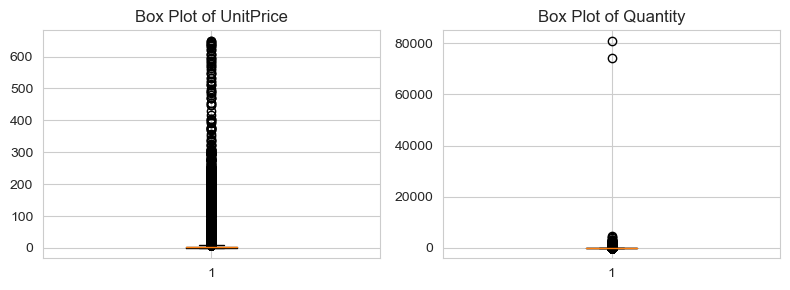

In [14]:
# Create a figure with a specific size
plt.figure(figsize=(8, 3))

# Box plot for 'UnitPrice'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.boxplot(df['UnitPrice'].dropna())
plt.title('Box Plot of UnitPrice')

# Box plot for 'Quantity'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.boxplot(df['Quantity'].dropna())
plt.title('Box Plot of Quantity')

# Adjust layout for better display
plt.tight_layout()
plt.show()

##### There are a lot of outliers in both quantity and price
##### There are 2 extreme outliers in quantity
##### Removing all outliers is risky here since it contains resonable outlier (high prices)
##### Looking at different percentiles can help in decesion  

In [15]:
# Define the quantile range from 98% to 99.9%
quantiles = [0.98, 0.99, 0.995, 0.999]

# Calculate quantiles for 'UnitPrice'
unitprice_quantiles = df['UnitPrice'].quantile(quantiles)

# Calculate quantiles for 'Quantity'
quantity_quantiles = df['Quantity'].quantile(quantiles)

# Display the quantiles
print("UnitPrice Quantiles (98th to 99.9th percentile):")
print(unitprice_quantiles)
print("\nQuantity Quantiles (98th to 99.9th percentile):")
print(quantity_quantiles)

UnitPrice Quantiles (98th to 99.9th percentile):
0.980     13.29000
0.990     16.95000
0.995     21.23000
0.999    125.94848
Name: UnitPrice, dtype: float64

Quantity Quantiles (98th to 99.9th percentile):
0.980     72.0
0.990    100.0
0.995    160.0
0.999    432.0
Name: Quantity, dtype: float64


##### The 99.9% percentile for prices looks reasonable, but we should'nt risk removing valid expensive products

In [16]:
display(df.sort_values(by='Quantity').tail(5))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
97400,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom
206083,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom
421335,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom
61603,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
540124,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


##### High quantities looks valid for retailers, but there are 2 very extreme outliers that should be removed

In [17]:
df = df[df['Quantity'] <= 5000]

In [18]:
display(df.sort_values(by='UnitPrice').tail(10))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
42056,539958,DOT,DOTCOM POSTAGE,1,2010-12-23 13:26:00,627.47,UnknownId,United Kingdom
501438,578827,DOT,DOTCOM POSTAGE,1,2011-11-25 14:25:00,634.39,UnknownId,United Kingdom
507648,579187,DOT,DOTCOM POSTAGE,1,2011-11-28 15:31:00,634.54,UnknownId,United Kingdom
389686,570488,DOT,DOTCOM POSTAGE,1,2011-10-10 17:12:00,635.01,14096.0,United Kingdom
416166,572552,DOT,DOTCOM POSTAGE,1,2011-10-24 17:07:00,638.30,14096.0,United Kingdom
370242,569137,DOT,DOTCOM POSTAGE,1,2011-09-30 14:45:00,639.83,UnknownId,United Kingdom
27268,538524,DOT,DOTCOM POSTAGE,1,2010-12-13 09:35:00,641.86,UnknownId,United Kingdom
496871,578347,DOT,DOTCOM POSTAGE,1,2011-11-24 09:26:00,644.28,UnknownId,United Kingdom
222644,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom
222642,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom


##### Removing 'DOTCOM POSTAGE' since it's invalid

In [19]:
# Filter out records with StockCode equal to 'DOT'
df = df[df['StockCode'] != 'DOT']

In [20]:
display(df.sort_values(by='UnitPrice').tail(15))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
183090,552648,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-05-10 13:40:00,195.00,17581.0,United Kingdom
220260,556181,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-06-09 11:32:00,195.00,15407.0,United Kingdom
182610,552560,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-05-10 11:48:00,195.00,17581.0,United Kingdom
112743,545900,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-03-07 17:42:00,195.00,17817.0,United Kingdom
135502,547901,AMAZONFEE,AMAZON FEE,1,2011-03-28 11:57:00,219.76,UnknownId,United Kingdom
171140,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.00,14973.0,United Kingdom
133962,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-25 14:19:00,295.00,13452.0,United Kingdom
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.00,13145.0,United Kingdom
51620,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.00,17406.0,United Kingdom
82752,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.00,14842.0,United Kingdom


##### Removing 'AMAZON FEE' since it's invalid

In [21]:
# Filter out records with StockCode equal to 'AMAZONFEE'
df = df[df['StockCode'] != 'AMAZONFEE']

In [22]:
display(df.sort_values(by='UnitPrice').tail(20))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
110811,545698,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-03-06 14:44:00,195.0,15572.0,United Kingdom
114763,546088,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-03-09 11:44:00,195.0,12881.0,United Kingdom
156699,550163,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-04-14 16:26:00,195.0,14154.0,United Kingdom
191562,553380,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-05-16 15:29:00,195.0,17190.0,United Kingdom
183090,552648,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-05-10 13:40:00,195.0,17581.0,United Kingdom
220260,556181,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-06-09 11:32:00,195.0,15407.0,United Kingdom
112743,545900,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-03-07 17:42:00,195.0,17817.0,United Kingdom
156961,550185,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-04-14 18:22:00,195.0,17142.0,United Kingdom
166073,550890,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-04-21 12:00:00,195.0,14711.0,United Kingdom
182610,552560,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-05-10 11:48:00,195.0,17581.0,United Kingdom


##### The high quantities seems like a valid transactions for retailers

### Data visualization after cleaning

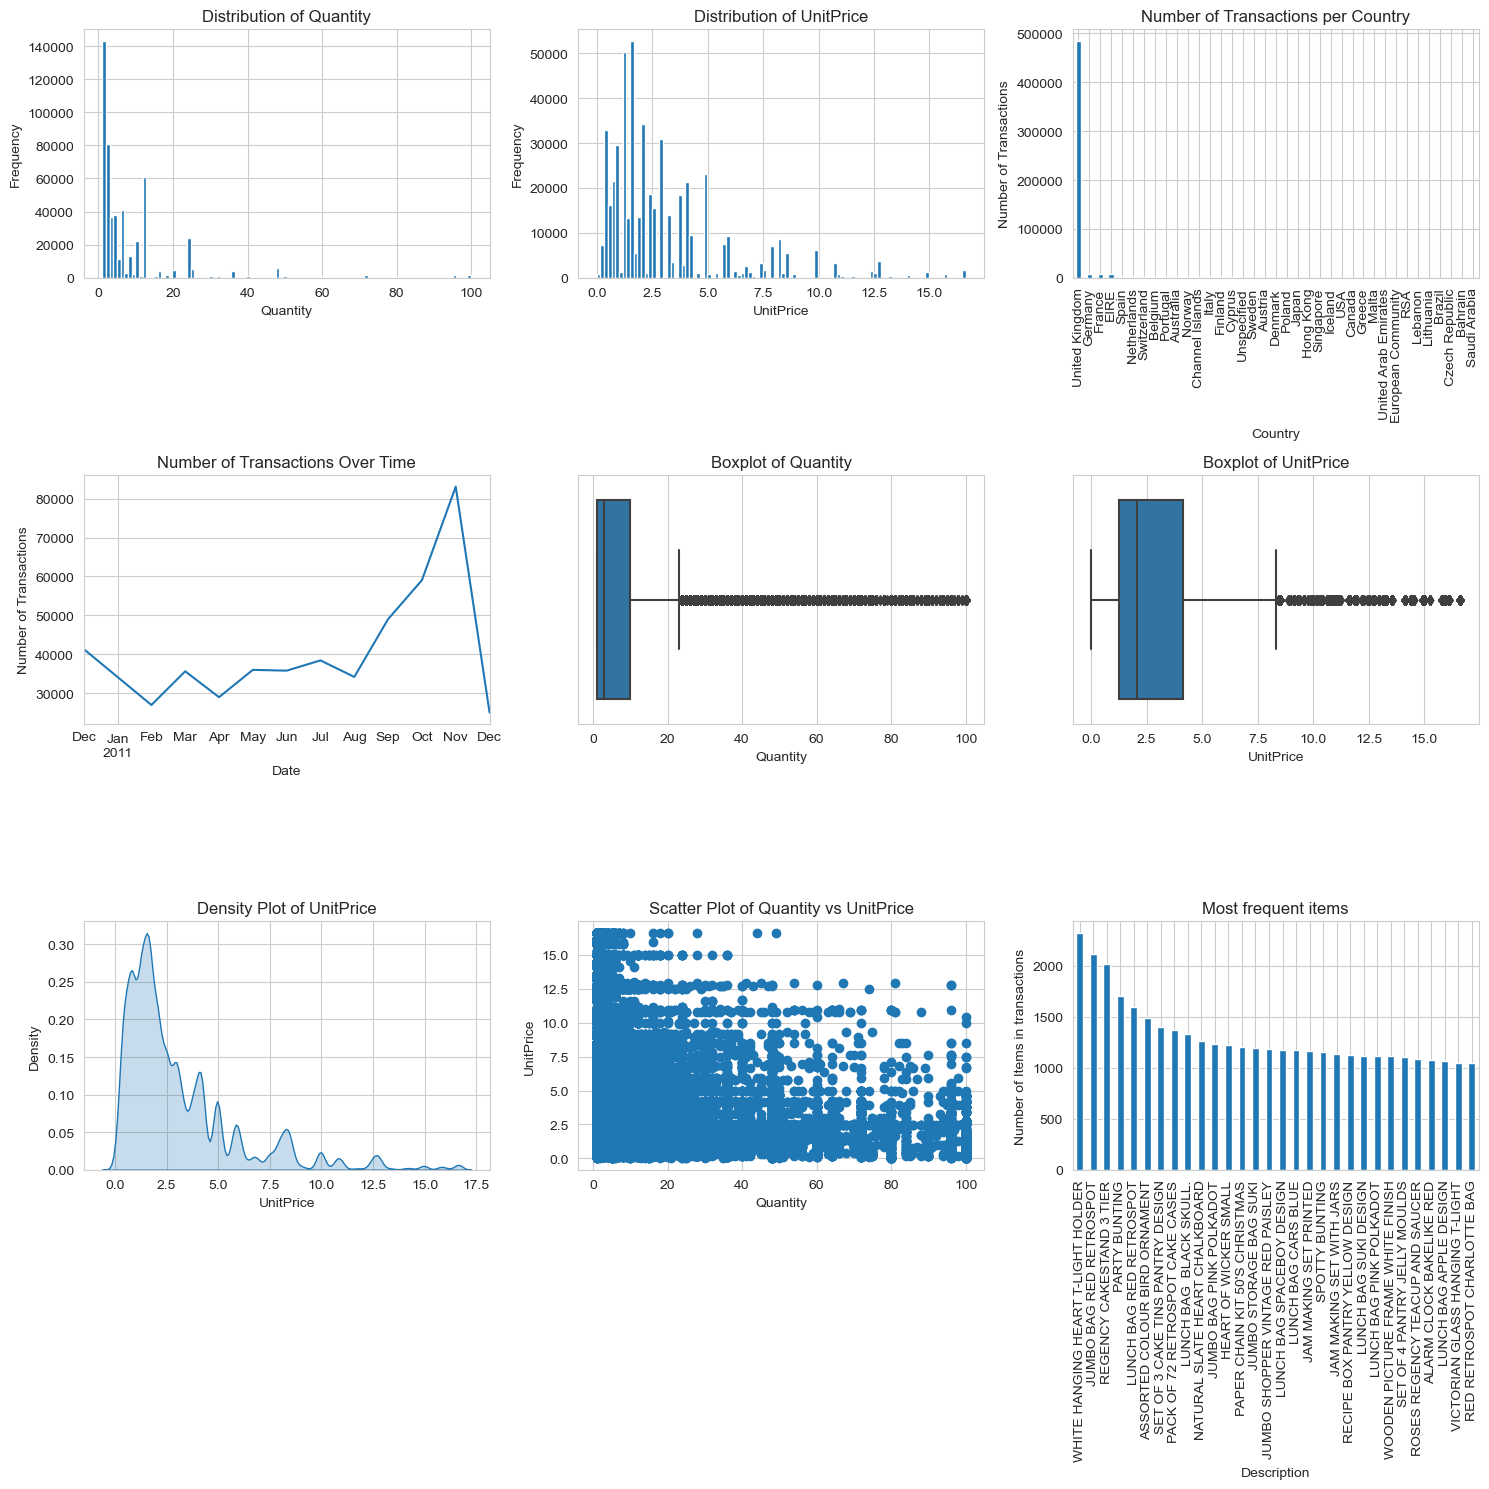

In [23]:
data_visualization(df, 0.99, 100)

##### We still have outliers but they are reasonable now, because of some expensive items and retailes
##### Most of the quantities are between 1-100
##### Most of the prices are between 0-20

#### Extending data for more analysis

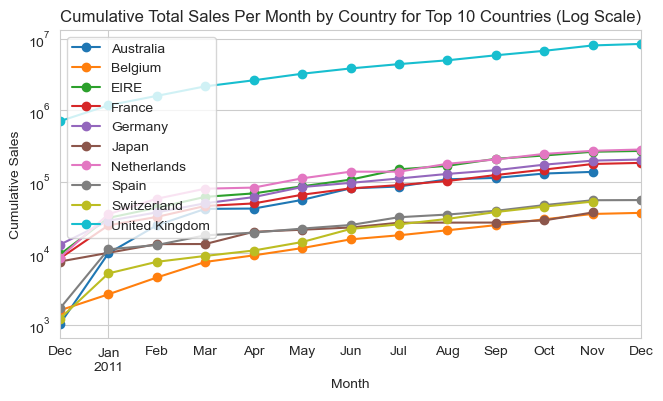

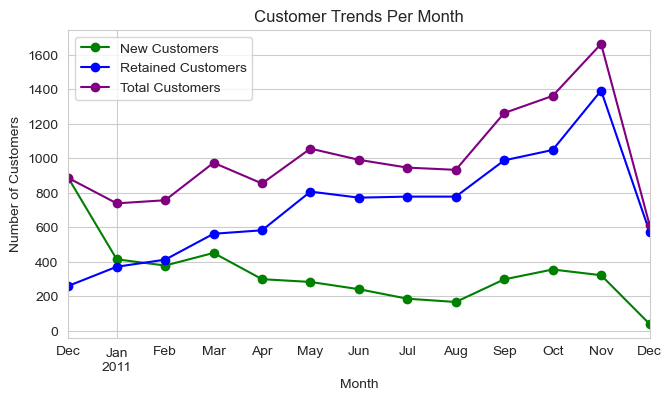

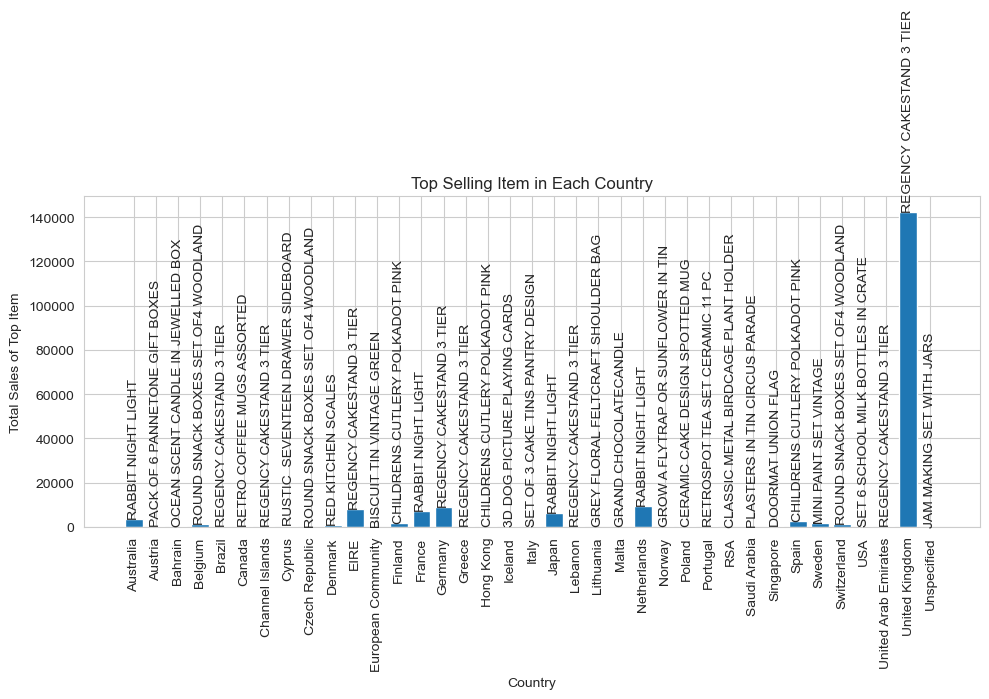

In [24]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
sales_for_top_countries(df)
customer_trend_per_month(df)
top_selling_items(df)

##### - The trend of the sales is increasing in a linear way. These stores are getting successful worldwide.
##### - The number of new customers was increasing first but start decreasing between March and August, then it recovered.
##### - The number of retained customers spiked on august.
##### -'REGENCY CAKESSTAND 3 TIER' is very popular worldwide. Check how it looks here https://www.royalcrownderby.co.uk/product/darley-abbey-pure-gold-three-tier-cake-stand-34cm/

In [25]:
df['Description'].value_counts().head(20)

WHITE HANGING HEART T-LIGHT HOLDER    2321
JUMBO BAG RED RETROSPOT               2112
REGENCY CAKESTAND 3 TIER              2014
PARTY BUNTING                         1704
LUNCH BAG RED RETROSPOT               1594
ASSORTED COLOUR BIRD ORNAMENT         1489
SET OF 3 CAKE TINS PANTRY DESIGN      1398
PACK OF 72 RETROSPOT CAKE CASES       1369
LUNCH BAG  BLACK SKULL.               1328
NATURAL SLATE HEART CHALKBOARD        1263
JUMBO BAG PINK POLKADOT               1237
HEART OF WICKER SMALL                 1226
PAPER CHAIN KIT 50'S CHRISTMAS        1200
JUMBO STORAGE BAG SUKI                1197
JUMBO SHOPPER VINTAGE RED PAISLEY     1189
LUNCH BAG SPACEBOY DESIGN             1178
LUNCH BAG CARS BLUE                   1174
JAM MAKING SET PRINTED                1168
SPOTTY BUNTING                        1157
JAM MAKING SET WITH JARS              1139
Name: Description, dtype: int64

#### Saving cleaned data

In [26]:
df.to_csv('cleaned_data.csv', index=False)